# Timeseries pytorch-lightning (CNN)

In [100]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plot
import math
from matplotlib import rc
from pylab import rcParams

import pandas as pd
import numpy as numpy
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [101]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter contrib nbextension install

In [102]:
%matplotlib inline
%config InlineBackend.figure_format='jpeg'
# !jupyter nbextension enable --py widgetsnbextension

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
tqdm.pandas()
pl.seed_everything(42)

Seed set to 42


42

## __Import dataset__

In [103]:
df = pd.read_csv('../datasets/household_power_consumption_v3_drop.txt', parse_dates={'datetime' : ['date','time']}, index_col='datetime', sep=';', usecols=[1,2,3,4,5,6,7,8,9,11,12,13])
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year
datetime,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


### Preprocessing

In [104]:
# rows = []

# for _, row in df.iterrows():
#     row_data = dict(
#         grp=row.global_reactive_power,
#         voltage=row.voltage,
#         global_intensity=row.global_intensity,
#         kitchen=row.kitchen,
#         laundry_room=row.laundry_room,
#         thermal_utilities=row.thermal_utilities,
#         day=row.day,
#         month=row.month,
#         year=row.year
#     )
#     rows.append(row_data)
# features_df = pd.DataFrame(rows)

In [105]:
cols = ['global_reactive_power', 'voltage', 'global_intensity', 'kitchen', 'laundry_room', 'thermal_utilities', 'day', 'month', 'year', 'global_active_power']
features_df = df[cols]
features_df

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006,4.216
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006,5.360
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006,5.374
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006,5.388
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006,3.666
...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.000,240.43,4.0,0.0,0.0,0.0,26,11,2010,0.946
2010-11-26 20:59:00,0.000,240.00,4.0,0.0,0.0,0.0,26,11,2010,0.944
2010-11-26 21:00:00,0.000,239.82,3.8,0.0,0.0,0.0,26,11,2010,0.938


In [106]:
cut_df = features_df[:500000]
train_size = int(len(cut_df) * .9)
train_size

450000

In [107]:
train_df, test_df = cut_df[:train_size], cut_df[train_size + 1:]
train_df.shape, test_df.shape

((450000, 10), (49999, 10))

In [108]:
# scalling data only using train df
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [109]:
train_df = pd.DataFrame(
    scaler.transform(train_df), 
    index=train_df.index, 
    columns=train_df.columns)
train_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.271777,-0.195321,-0.217391,-1.0,-0.974359,0.7,0.0,1.0,-1.0,-0.219116
2006-12-16 17:25:00,-0.240418,-0.281106,-0.017391,-1.0,-0.974359,0.6,0.0,1.0,-1.0,-0.003022
2006-12-16 17:26:00,-0.132404,-0.305211,-0.017391,-1.0,-0.948718,0.7,0.0,1.0,-1.0,-0.000378


In [110]:
test_df = pd.DataFrame(
    scaler.transform(test_df), 
    index=test_df.index, 
    columns=test_df.columns)
test_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2007-10-27 22:57:00,-1.000000,0.453385,-0.982609,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:58:00,-0.850174,0.450549,-0.956522,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.958444
2007-10-27 22:59:00,-0.850174,0.441333,-0.965217,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.961844


__To sequences__

In [199]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, offset = 1):
    sequences = []
    data_size = len(input_data)
    
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i+sequence_length]
        
        label_poisition = i+sequence_length
        label = input_data.iloc[label_poisition:label_poisition+offset][target_column]
        
        sequences.append((sequence, label))
        
    return sequences

In [200]:
input_data = train_df[:100]

train_df[:500000]

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.271777,-0.195321,-0.217391,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,-0.219116
2006-12-16 17:25:00,-0.240418,-0.281106,-0.017391,-1.0,-0.974359,0.6,0.000000,1.000000,-1.0,-0.003022
2006-12-16 17:26:00,-0.132404,-0.305211,-0.017391,-1.0,-0.948718,0.7,0.000000,1.000000,-1.0,-0.000378
2006-12-16 17:27:00,-0.125436,-0.273307,-0.017391,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,0.002267
2006-12-16 17:28:00,-0.080139,-0.135767,-0.330435,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,-0.323007
...,...,...,...,...,...,...,...,...,...,...
2007-10-27 22:51:00,-1.000000,0.431407,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:52:00,-1.000000,0.463311,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:53:00,-1.000000,0.473945,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199


In [201]:
train_seq = create_sequences(input_data, 'global_active_power', 20, 1)
len(train_seq[0])

2

In [202]:
print(f'Train sequence shape (features): {train_seq[0][0].shape}; (labels): {train_seq[0][1].shape}')

Train sequence shape (features): (20, 10); (labels): (1,)


In [203]:
num_seq = 60 # 60 minutes
offset = 1
train_sequences = create_sequences(train_df, 'global_active_power', num_seq, offset)
test_sequences = create_sequences(test_df, 'global_active_power', num_seq, offset)


In [205]:
print(len(train_sequences))
print(len(train_sequences[0]))
print(len(train_sequences[0][0]))
print(len(train_sequences[0][1]))

449940
2
60
1


In [206]:
train_sequences[0][0].values.shape

(60, 10)

In [207]:
len(train_sequences)

449940

### Create pytorch dataset (time-series)

https://www.youtube.com/watch?v=ODEGJ_kh2aA

In [208]:
class PCDataset(Dataset):
    def __init__(self, sequences):
        # super().__init__()
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device='cuda') if torch.cuda.is_available() else torch.Tensor(sequence.to_numpy()), # put to cuda device if available
            label = torch.Tensor(label).float().to(device='cuda') if torch.cuda.is_available() else torch.Tensor(label).float() # put to cuda device if available
        )
        

In [209]:
class PCDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        print('batch size', self.batch_size)
    def setup(self, stage=None):
        self.train_dataset = PCDataset(self.train_sequences)
        self.test_dataset = PCDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )

In [210]:
# # d = PCDataModule(train_sequences, test_sequences)
# dl = DataLoader(
#     PCDataset(train_sequences),
#     batch_size=8,
#     shuffle=False
# )

# for d in dl:
#     print(d['sequence'].shape)
#     break

In [211]:
num_epoch = 5
batch_size = 64

data_module = PCDataModule(train_sequences, test_sequences, batch_size)
data_module.setup()

batch size 64


In [212]:
train_dataset = PCDataset(train_sequences)

In [213]:
len(train_sequences)

449940

In [214]:
# train_dataset.__len__()

for item in train_dataset:
    print(item['sequence'].shape)
    break
    print(item['sequence'].shape)
    print(item['label'].shape)
    print(item['label'])
    break

torch.Size([60, 10])


### Model

In [215]:
# batch_size = 3
# feature_dim = 256
# time_step = 16000
# hidden_channels = 128

# x = torch.rand(batch_size, feature_dim, time_step)
# print('input_size:', x.shape)

# conv1 = nn.Conv1d(
#     in_channels=feature_dim,
#     out_channels=hidden_channels,
#     kernel_size=2
# ) # feature_dim, hidden_channels, kernel_size=2
# print('kernel_size:', conv1.weight.shape)

# conv2 = nn.Conv1d(
#     in_channels=hidden_channels,
#     out_channels=hidden_channels,
#     kernel_size=2
# )
# print('kernel_size_2:', conv2.weight.shape)


# # POOL 1D
# pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
# pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


# # NETWORK
# out = conv1(x)
# print('output_size_1:',out.shape)
# out = out.relu()
# out = pool1(out)
# print('output_size_pool:',out.shape)


# out = conv2(out)
# print('output_size_2:',out.shape)
# out = out.relu()
# out = pool2(out)
# print('output_size_pool:',out.shape)
# out.shape

# out = torch.flatten(out, start_dim=1)
# print('flat (view)', out.shape[1])

# lin = nn.Linear(in_features=out.shape[1], out_features=32)
# lin2 = nn.Linear(in_features=32, out_features=60)

# out = lin(out)
# y = lin2(out)
# print(y)


In [216]:
print(x.shape)

print(x[0])

torch.Size([3, 256, 16000])
tensor([[0.7642, 0.5346, 0.1751,  ..., 0.1733, 0.8096, 0.2516],
        [0.7883, 0.8308, 0.3691,  ..., 0.3944, 0.6556, 0.1015],
        [0.3769, 0.0835, 0.7669,  ..., 0.3821, 0.1119, 0.9800],
        ...,
        [0.8161, 0.7185, 0.3329,  ..., 0.5293, 0.5503, 0.6988],
        [0.5182, 0.9591, 0.7311,  ..., 0.8972, 0.0770, 0.6885],
        [0.3396, 0.6341, 0.5553,  ..., 0.4662, 0.3818, 0.9170]])


In [318]:

# CNN
class Model(nn.Module):
    def __init__(self, n_features, n_hidden=64, kernel_size=2):
        super(Model, self).__init__()
        self.n_hidden = n_hidden
        
        # convolution layer
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=kernel_size)
        
        # pooling layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        
        # linear
        self.lin1 = None
        self.lin2 = None
        
        self.initialized = False
    
    def forward(self, x):
        
        # print("shape", x.shape)
        x = x.transpose(1,2)
        # conv1
        x = self.conv1(x)
        x = x.relu()
        x = self.pool1(x)
        
        # conv2
        x = self.conv2(x)
        x = x.relu()
        x = self.pool2(x)
        
        # flatten
        x = torch.flatten(x, start_dim=1)
        
        # Dynamically create linear layers if not already created
        if not self.initialized:
            n_size = x.size(1)
            self.lin1 = nn.Linear(n_size, 32).to(x.device)
            self.lin2 = nn.Linear(32, 1).to(x.device)
            self.initialized = True
            
        # Linear layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        
        return x

In [319]:
# class Model(nn.Module):
#     def __init__(self, n_features, n_hidden=128, n_layers=2) -> None:
#         super().__init__()
#         self.n_hidden = n_hidden
#         self.lstm = nn.LSTM(
#             input_size=n_features, #input feature
#             hidden_size=n_hidden,
#             batch_first=True,
#             num_layers=n_layers,
#             dropout=0.2
#         )
        
#         self.regressor = nn.Linear(n_hidden, 1) # final layer for prediction
        
#     def forward(self, x):
#         self.lstm.flatten_parameters()
        
#         _, (hidden, _) = self.lstm(x) # take the hidden state
#         out = hidden[-1] # take the last layer, which contains the features
        
#         return self.regressor(out)

In [330]:
from typing import Any


from pytorch_lightning.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class PCPredictor(pl.LightningModule):
    def __init__(self, n_features: int, model = Model):
        super().__init__()
        self.model = Model(n_features)
        self.criterion = nn.MSELoss() #loss function
    
    def forward(self,x,labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            # print("output", output)
            
            # print("labels", labels)
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):# -> OptimizerLRScheduler:
        return optim.Adam(self.parameters(), lr=0.0001)

In [331]:
train_df.shape

(450000, 10)

In [332]:
model = PCPredictor(train_df.shape[1])

In [333]:
data_module.train_dataloader()

In [334]:
for item in data_module.train_dataloader():
    # print(item.keys())
    # break
    print(item['sequence'].shape)
    print(item['label'].shape)
    # print(item['label'])
    
    break

torch.Size([64, 60, 10])
torch.Size([64, 1])


In [335]:
import tensorboard

In [336]:
%reload_ext tensorboard

%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 10996), started 5:42:01 ago. (Use '!kill 10996' to kill it.)

In [337]:
checkpoint_callback = ModelCheckpoint(
    dirpath='../checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='pc')

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    callbacks=[checkpoint_callback],
    max_epochs=num_epoch,
    accelerator="gpu",
    devices=1,
    # progress_bar_refresh_rate=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [338]:
for d in data_module.train_dataloader():
    print(d['label'].unsqueeze(dim=1))
    break

tensor([[[-0.3634]],

        [[-0.0956]],

        [[-0.0960]],

        [[-0.0963]],

        [[-0.4156]],

        [[-0.4639]],

        [[-0.4620]],

        [[-0.4654]],

        [[-0.5229]],

        [[-0.5028]],

        [[-0.3472]],

        [[ 0.1315]],

        [[-0.1587]],

        [[-0.1828]],

        [[-0.4654]],

        [[-0.5761]],

        [[-0.5878]],

        [[-0.5867]],

        [[-0.5890]],

        [[-0.6022]],

        [[-0.4530]],

        [[-0.2221]],

        [[-0.2214]],

        [[-0.2187]],

        [[-0.4892]],

        [[-0.5357]],

        [[-0.5440]],

        [[-0.5742]],

        [[-0.5769]],

        [[-0.5531]],

        [[-0.2036]],

        [[-0.2165]],

        [[-0.2165]],

        [[-0.2743]],

        [[-0.2187]],

        [[-0.2176]],

        [[-0.2467]],

        [[-0.3332]],

        [[-0.3623]],

        [[-0.3668]],

        [[-0.3797]],

        [[-0.3725]],

        [[-0.3767]],

        [[-0.3325]],

        [[-0.3589]],

        [[

In [339]:
trainer.fit(model, data_module)

# ERR: Given groups=1, weight of size [64, 10, 2], expected input[64, 60, 10] to have 10 channels, but got 60 channels instead

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | Model   | 9.6 K 
1 | criterion | MSELoss | 0     
--------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.038     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\sclab\anaconda3\envs\xai\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\sclab\anaconda3\envs\xai\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19, 1, 1])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 7031: 'val_loss' reached 0.01904 (best 0.01904), saving model to '../checkpoints\\best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 14062: 'val_loss' reached 0.01868 (best 0.01868), saving model to '../checkpoints\\best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 21093: 'val_loss' reached 0.01856 (best 0.01856), saving model to '../checkpoints\\best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 28124: 'val_loss' reached 0.01833 (best 0.01833), saving model to '../checkpoints\\best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 35155: 'val_loss' reached 0.01826 (best 0.01826), saving model to '../checkpoints\\best-checkpoint-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [229]:
m = Model(n_features=df.shape[1], n_hidden=64, kernel_size=2)
# m()
# for d in data_module.train_dataloader()

### Test dataset

In [ ]:
# optional

trained_model = PCPredictor.load_from_checkpoint(
    '../checkpoints/best-checkpoint-v1.ckpt', 
    n_features=train_df.shape[1]
)

In [357]:
test_dataset = PCDataset(test_sequences)

predictions = []
labels = []
model.to(torch.device('cuda'))

for item in test_dataset:
    
    # print(item['sequence'])
    # break
    sequence = item['sequence']
    label = item['label']
    
    _, output = model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

In [356]:
# next(model.parameters()).is_cuda
# for name, p in model.named_parameters():
#     print(name)

# for d in test_dataset:
#     print(d['sequence'])
#     break

model.conv1.weight
model.conv1.bias
model.conv2.weight
model.conv2.bias
model.lin1.weight
model.lin1.bias
model.lin2.weight
model.lin2.bias


In [358]:
print(len(predictions), len(test_df) - 60)

49939 49939


### Descalling

In [362]:
# print(labels)
# print(test_df.iloc[60:]['global_active_power'].values)
result_df = pd.DataFrame(
    {
        'predictions': predictions,
        'labels': labels
    }
)

In [363]:

import matplotlib.pyplot as plt
%matplotlib inline

In [364]:
result_df.index.values

array([    0,     1,     2, ..., 49936, 49937, 49938], dtype=int64)

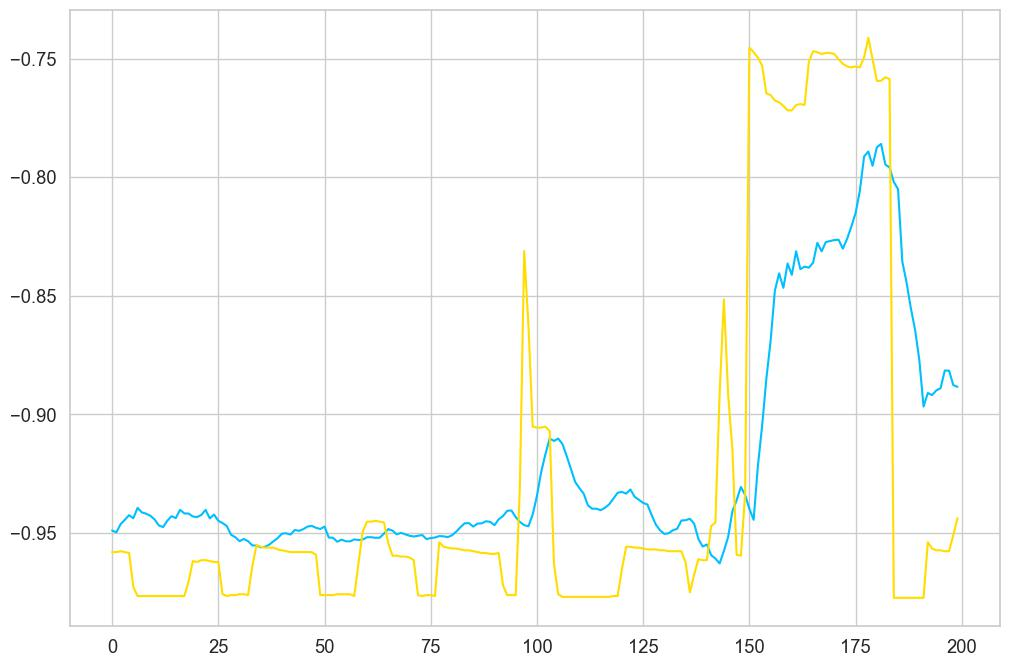

In [365]:
plt.plot(result_df.index.values[:200], result_df.predictions.values[:200])
plt.plot(result_df.index.values[:200], result_df.labels.values[:200])
plt.show()

<Axes: >

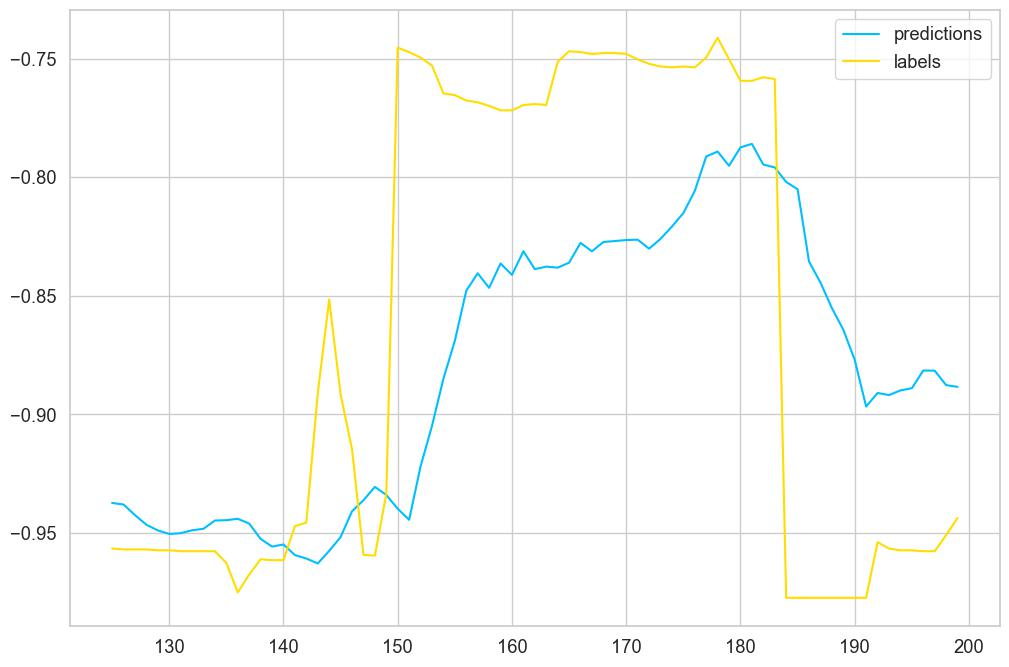

In [366]:
result_df[125:200].plot()

### MSE

In [367]:
from torchmetrics.regression import MeanSquaredError

In [374]:
mse = MeanSquaredError()
mse(torch.tensor(result_df['predictions'].values), torch.tensor(result_df['labels'].values))

tensor(0.0124)

In [373]:
torch.tensor(result_df['predictions'].values)

tensor([-0.9490, -0.9497, -0.9463,  ..., -0.6482, -0.6406, -0.6480],
       dtype=torch.float64)

# MSE LOSS

In [377]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
# output.backward()
input.shape
target.shape

torch.Size([3, 5])